We chose to analyze the __20 newsgroups text dataset__. Our document is structured as follows:

0. Exploring Basic Structure of the Dataset
1. Understanding the Dataset
2. Data Preprocessing
3. Classification Using Support Vector Machines
4. Trying a Hierarchical Learning Approach
5. Classification Using Neural Networks
6. Hyperparameter Tuning
7. Insights on Misclassified Data
8. Conclusion

In [1]:
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import string
import nltk
import itertools
nltk.download('punkt')
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\evabr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
import ssl
import certifi
import urllib.request
from sklearn.datasets import fetch_20newsgroups

# Apply certifi's certificate bundle to urllib
ssl_context = ssl.create_default_context(cafile=certifi.where())
urllib.request.urlopen('https://pypi.org', context=ssl_context)

# Monkey patch the urlopen function to use the custom SSL context
def patched_urlopen(*args, **kwargs):
    kwargs['context'] = ssl_context
    return original_urlopen(*args, **kwargs)

original_urlopen = urllib.request.urlopen
urllib.request.urlopen = patched_urlopen

# 0. Exploring Basic Structure of the Dataset

In [3]:
# Fetch the training subset of the 20 newsgroups dataset
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

# Check the fetched data
print(f"Number of training samples: {len(newsgroups_train.data)}")
print(f"Number of test samples: {len(newsgroups_test.data)}")
print(f"Number of target names: {len(newsgroups_train.target_names)}")

Number of training samples: 11314
Number of test samples: 7532
Number of target names: 20


In [4]:
newsgroups_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [5]:
print(newsgroups_train.target.shape)
print(newsgroups_train.target[:10])
newsgroups_train.target

(11314,)
[ 7  4  4  1 14 16 13  3  2  4]


array([7, 4, 4, ..., 3, 1, 8])

Printing the categories and corresponding indexes:

In [6]:
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))

# Get unique target labels
unique_targets = set(newsgroups_train.target)

# Map target labels to their corresponding category names
target_categories = [newsgroups_train.target_names[target] for target in unique_targets]

# Print the unique target labels and their corresponding category names
for target, category in zip(unique_targets, target_categories):
    print(f"Label: {target}, Category Name: {category}")

Label: 0, Category Name: alt.atheism
Label: 1, Category Name: comp.graphics
Label: 2, Category Name: comp.os.ms-windows.misc
Label: 3, Category Name: comp.sys.ibm.pc.hardware
Label: 4, Category Name: comp.sys.mac.hardware
Label: 5, Category Name: comp.windows.x
Label: 6, Category Name: misc.forsale
Label: 7, Category Name: rec.autos
Label: 8, Category Name: rec.motorcycles
Label: 9, Category Name: rec.sport.baseball
Label: 10, Category Name: rec.sport.hockey
Label: 11, Category Name: sci.crypt
Label: 12, Category Name: sci.electronics
Label: 13, Category Name: sci.med
Label: 14, Category Name: sci.space
Label: 15, Category Name: soc.religion.christian
Label: 16, Category Name: talk.politics.guns
Label: 17, Category Name: talk.politics.mideast
Label: 18, Category Name: talk.politics.misc
Label: 19, Category Name: talk.religion.misc


In [7]:
print(newsgroups_train.filenames.shape)
print(newsgroups_train.filenames[:2])

(11314,)
['C:\\Users\\evabr\\scikit_learn_data\\20news_home\\20news-bydate-train\\rec.autos\\102994'
 'C:\\Users\\evabr\\scikit_learn_data\\20news_home\\20news-bydate-train\\comp.sys.mac.hardware\\51861']


### Printing the first 3 sample documents:

In [8]:
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

# Number of samples to view
num_samples = 3

# Print the first samples
for i in range(num_samples):
    category_index = newsgroups_train.target[i]
    category_name = newsgroups_train.target_names[category_index]
    print(f"Document {i+1} (Category: {category_name}):\n")
    print(newsgroups_train.data[i])
    print("\n" + "="*80 + "\n")

Document 1 (Category: rec.autos):

I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.


Document 2 (Category: comp.sys.mac.hardware):

A fair number of brave souls who upgraded their SI clock oscillator have
shared their experiences for this poll. Please send a brief message detailing
your experiences with the procedure. Top speed attained, CPU rated speed,
add on cards and adapters, heat sinks, hour of usage per day, floppy disk
functionality with 800 and 1.4 m floppies are especially requested.

I will be summarizing in the next two days, so please add to the network

### Printing one sample document for each category

In [9]:

unique_targets = set(newsgroups_train.target)

# Map target labels to their corresponding category names
target_categories = [newsgroups_train.target_names[target] for target in unique_targets]

# Print one document from each category
for target, category in zip(unique_targets, target_categories):
    # Find the index of the first document in the current category
    for idx, label in enumerate(newsgroups_train.target):
        if label == target:
            print(f"Category: {category}")
            print(newsgroups_train.data[idx])
            print("\n" + "="*80 + "\n")
            break

Category: alt.atheism

Don't be so sure.  Look what happened to Japanese citizens in the US during
World War II.  If you're prepared to say "Let's round these people up and
stick them in a concentration camp without trial", it's only a short step to
gassing them without trial.  After all, it seems that the Nazis originally
only intended to imprison the Jews; the Final Solution was dreamt up partly
because they couldn't afford to run the camps because of the devastation
caused by Goering's Total War.  Those who weren't gassed generally died of
malnutrition or disease.



Category: comp.graphics

Do you have Weitek's address/phone number?  I'd like to get some information
about this chip.



Category: comp.os.ms-windows.misc
I have win 3.0 and downloaded several icons and BMP's but I can't figure out
how to change the "wallpaper" or use the icons.  Any help would be appreciated.


Thanx,

-Brando


Category: comp.sys.ibm.pc.hardware
                                                       

In order to feed predictive or clustering models with the text data, one first need to turn the text into vectors of numerical values suitable for statistical analysis. This can be achieved with the utilities of the sklearn.feature_extraction.text.

# 1. Understanding the Dataset

### 1.1. Number of Documents per Category

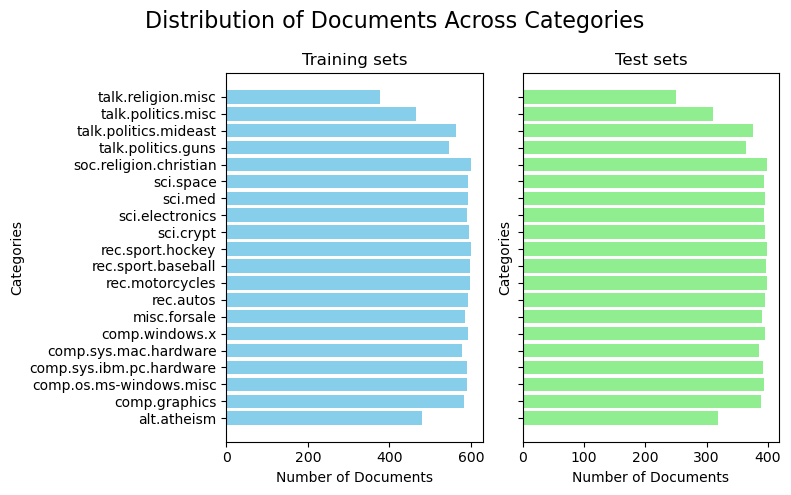

In [17]:
# Load the dataset
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))
categories = newsgroups_train.target_names
data_train = newsgroups_train.data
data_test = newsgroups_test.data
targets_train = newsgroups_train.target
targets_test = newsgroups_test.target

fig, axs = plt.subplots(1,2, figsize=(8,5), sharey=True)

plt.suptitle('Distribution of Documents Across Categories',fontsize=16)

# 1. Distribution of documents across categories
category_counts_train = Counter(targets_train)
category_counts_test = Counter(targets_test)
sets = [category_counts_train, category_counts_test]
colors = ['skyblue', 'lightgreen']

for i,data_set in zip(np.arange(2),sets):
    axs[i].barh(categories, [data_set[j] for j in range(len(categories))], color = colors[i])
    axs[i].set_xlabel('Number of Documents')
    axs[i].set_ylabel('Categories')

axs[0].set_title('Training sets')
axs[1].set_title('Test sets')
plt.tight_layout()
plt.show()


The majority of the categories have a similar number of documents, both in the test and training set. However, in both sets, it is visible that the categories talk.religion.misc, talk.politics.misc, and alt.atheism have fewer samples than the average.

### 1.2. Average Number of Words, Characters, and Special Characters in Documents per Category

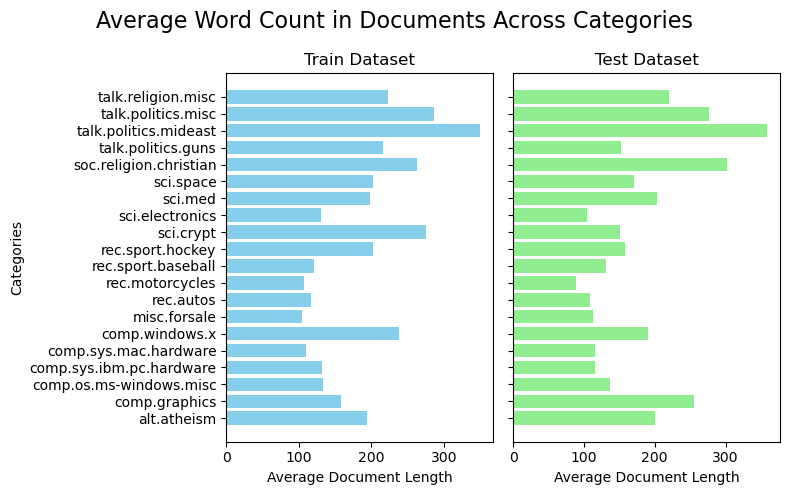

In [8]:
# Fetch the 20newsgroups dataset
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

# Function to calculate average number of words of documents in each category
def average_word_count(data):
    category_lengths = {i: [] for i in range(len(data.target_names))}
    
    for text, target in zip(data.data, data.target):
        category_lengths[target].append(len(text.split()))
    
    avg_lengths = {category: np.mean(lengths) for category, lengths in category_lengths.items()}
    return avg_lengths

# Calculate average document lengths for train and test datasets
train_avg_lengths = average_word_count(newsgroups_train)
test_avg_lengths = average_word_count(newsgroups_test)

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,5), sharey=True)

# Train dataset plot
ax1.barh(newsgroups_train.target_names, list(train_avg_lengths.values()), color='skyblue')
ax1.set_title('Train Dataset')
ax1.set_xlabel('Average Document Length')
ax1.set_ylabel('Categories')

# Test dataset plot
ax2.barh(newsgroups_test.target_names, list(test_avg_lengths.values()), color='lightgreen')
ax2.set_title('Test Dataset')
ax2.set_xlabel('Average Document Length')

# Add a main title for the whole plot
fig.suptitle('Average Word Count in Documents Across Categories', fontsize=16)

plt.tight_layout()  # Adjust layout to make room for the title
plt.show()


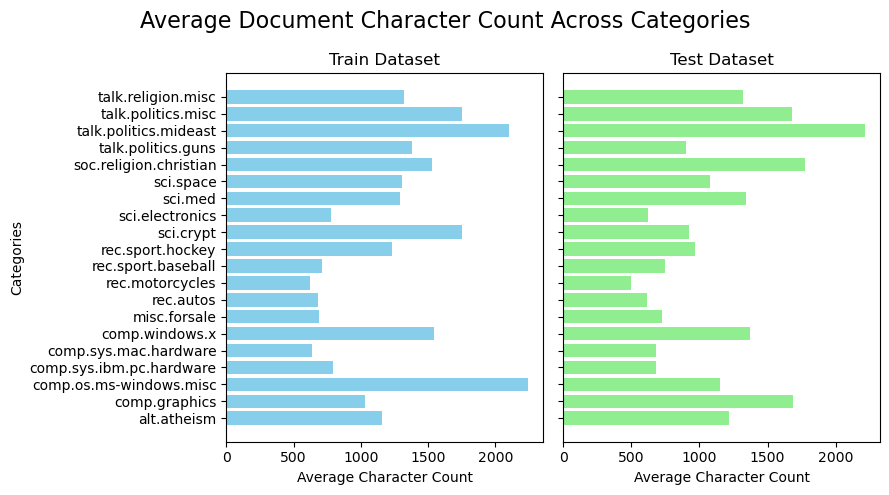

In [12]:
# Fetch the 20newsgroups dataset
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

# Function to calculate average length of documents (in characters) in each category
def average_character_count(data):
    category_lengths = {i: [] for i in range(len(data.target_names))}
    
    for text, target in zip(data.data, data.target):
        category_lengths[target].append(len(text))
    
    avg_lengths = {category: np.mean(lengths) for category, lengths in category_lengths.items()}
    return avg_lengths

# Calculate average character lengths for train and test datasets
train_avg_lengths = average_character_count(newsgroups_train)
test_avg_lengths = average_character_count(newsgroups_test)

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,5), sharey=True)

# Train dataset plot
ax1.barh(newsgroups_train.target_names, list(train_avg_lengths.values()), color='skyblue')
ax1.set_title('Train Dataset')
ax1.set_xlabel('Average Character Count')
ax1.set_ylabel('Categories')

# Test dataset plot
ax2.barh(newsgroups_test.target_names, list(test_avg_lengths.values()), color='lightgreen')
ax2.set_title('Test Dataset')
ax2.set_xlabel('Average Character Count')

# Add a main title for the whole plot
fig.suptitle('Average Document Character Count Across Categories', fontsize=16)

plt.tight_layout()  # Adjust layout to make room for the title
plt.show()


In [13]:
newsgroups_train.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

In [14]:
print(string.punctuation)
print(string.digits)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
0123456789


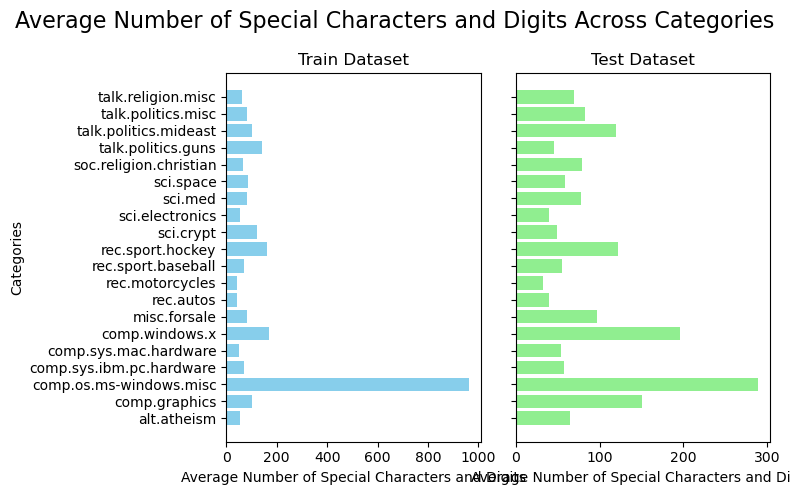

In [15]:
# Fetch the 20newsgroups dataset
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

# Function to calculate average number of special characters and digits in each category
def average_special_and_digit_length(data):
    special_characters_and_digits = string.punctuation + string.digits
    category_special_lengths = {i: [] for i in range(len(data.target_names))}
    
    for text, target in zip(data.data, data.target):
        special_char_count = sum(1 for char in text if char in special_characters_and_digits)
        category_special_lengths[target].append(special_char_count)
    
    avg_special_lengths = {category: np.mean(lengths) for category, lengths in category_special_lengths.items()}
    return avg_special_lengths

# Calculate average special character and digit lengths for train and test datasets
train_avg_special_lengths = average_special_and_digit_length(newsgroups_train)
test_avg_special_lengths = average_special_and_digit_length(newsgroups_test)

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,5), sharey=True)

# Train dataset plot
ax1.barh(newsgroups_train.target_names, list(train_avg_special_lengths.values()), color='skyblue')
ax1.set_title('Train Dataset')
ax1.set_xlabel('Average Number of Special Characters and Digits')
ax1.set_ylabel('Categories')

# Test dataset plot
ax2.barh(newsgroups_test.target_names, list(test_avg_special_lengths.values()), color='lightgreen')
ax2.set_title('Test Dataset')
ax2.set_xlabel('Average Number of Special Characters and Digits')

# Add a main title for the whole plot
fig.suptitle('Average Number of Special Characters and Digits Across Categories', fontsize=16)

plt.tight_layout()  # Adjust layout to make room for the title
plt.show()

# 2. Data Preprocessing

### 2.1. Throw out empty documents and convert text to lowercase


In [3]:
# Fetch the 20newsgroups dataset
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

In [4]:
# How many articles are empty/ are just several blanks or consist of very few words?
counter_empty = 0
counter_short = 0
for i in newsgroups_train.data:
    if not bool(i.strip()):
        counter_empty += 1
    if len(i.strip())<=10:
        counter_short += 1

print('There are',counter_short,'many articles which have less than 10 characters.',counter_empty,'of them are empty.' )

There are 331 many articles which have less than 10 characters. 300 of them are empty.


In [5]:
def remove_empty_articles(X,y):
    indices = []
    empty_articles = []
    for i in range(len(X)):
        text = X[i]
        if not bool(text.strip()):
            indices.append(i) 
            empty_articles.append(text)
    X_out = [i for i in X if i not in empty_articles]
    y_out = np.delete(y,indices)
    return X_out, y_out

In [6]:
# Filter empty documents
filtered_list_train,filtered_targets_train = remove_empty_articles(newsgroups_train.data,newsgroups_train.target)
filtered_list_test,filtered_targets_test = remove_empty_articles(newsgroups_test.data,newsgroups_test.target)

print("Number of all training documents: ", len(newsgroups_train.data))
print("Number of training documents that have a non-empty body: ", len(filtered_list_train))
print("Number of all test documents: ", len(newsgroups_test.data))
print("Number of test documents that have a non-empty body: ", len(filtered_list_test))

# Normalization: Convert text to lowercase
normalized_train_data = [doc.lower() for doc in filtered_list_train]
normalized_test_data = [doc.lower() for doc in filtered_list_test]

Number of all training documents:  11314
Number of training documents that have a non-empty body:  11014
Number of all test documents:  7532
Number of test documents that have a non-empty body:  7317


### 2.2. Remove Stop Words

In [7]:
# we could add additional stop words
stop_words = ENGLISH_STOP_WORDS
# Function to remove stop words from a document
def remove_stop_words(doc):
    return ' '.join([word for word in doc.split() if word not in stop_words])

# Remove stop words from the normalized datasets
processed_train_data = [remove_stop_words(doc) for doc in normalized_train_data]
processed_test_data = [remove_stop_words(doc) for doc in normalized_test_data]


### 2.3. Apply stemming with Porter Stemmer

In [8]:
# Initialize the Porter Stemmer
stemmer = PorterStemmer()

# Function to apply stemming to a document
def apply_stemming(doc):
    tokens = word_tokenize(doc)
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return stemmed_tokens

# Apply stemming to the processed datasets
stemmed_train_data = [apply_stemming(doc) for doc in processed_train_data]
stemmed_test_data = [apply_stemming(doc) for doc in processed_test_data]

#### Done with the preprocessing, let's compare the preprocessed data with the original data.

In [12]:
print(filtered_list_test[0])
print("\n" + "="*80 + "\n")
print(filtered_list_test[1])

I am a little confused on all of the models of the 88-89 bonnevilles.
I have heard of the LE SE LSE SSE SSEI. Could someone tell me the
differences are far as features or performance. I am also curious to
know what the book value is for prefereably the 89 model. And how much
less than book value can you usually get them for. In other words how
much are they in demand this time of year. I have heard that the mid-spring
early summer is the best time to buy.


I'm not familiar at all with the format of these "X-Face:" thingies, but
after seeing them in some folks' headers, I've *got* to *see* them (and
maybe make one of my own)!

I've got "dpg-view" on my Linux box (which displays "uncompressed X-Faces")
and I've managed to compile [un]compface too... but now that I'm *looking*
for them, I can't seem to find any X-Face:'s in anyones news headers!  :-(

Could you, would you, please send me your "X-Face:" header?

I *know* I'll probably get a little swamped, but I can handle it.

	...I hope

In [13]:
print(' '.join(stemmed_test_data[0]))
print("\n" + "="*80 + "\n")
print(' '.join(stemmed_test_data[1]))

littl confus model 88-89 bonnevil . heard le se lse sse ssei . tell differ far featur perform . curiou know book valu prefer 89 model . book valu usual for . word demand time year . heard mid-spr earli summer best time buy .


i 'm familiar format `` x-face : '' thingi , see folk ' header , i 've * got * * see * ( and mayb make own ) ! i 've got `` dpg-view '' linux box ( which display `` uncompress x-face '' ) i 've manag compil [ un ] compfac too ... i 'm * look * them , ca n't x-face : 's anyon news header ! : - ( you , you , send `` x-face : '' header ? * know * i 'll probabl littl swamp , handl it . ... i hope .


### 2.4 Collect all steps in a preprocess function

In [9]:
# Function to remove stop words from a document
def remove_stop_words(doc):
    return ' '.join([word for word in doc.split() if word not in stop_words])

# Function to apply stemming to a document
def apply_stemming(doc):
    tokens = word_tokenize(doc)
    stemmed_tokens = ' '.join([stemmer.stem(token) for token in tokens])
    return stemmed_tokens


def preprocess(data, targets, rm_stop_words = True, use_stemming = True):

    # 1. Filter empty documents
    data,targets = remove_empty_articles(data,targets)

    # 2. Normalization: Convert text to lowercase
    data = [doc.lower() for doc in data]

    # 3. Remove stop words
    if rm_stop_words:
        # we could add additional stop words
        stop_words = ENGLISH_STOP_WORDS

        # Remove stop words from the normalized datasets
        data = [remove_stop_words(doc) for doc in data]

    # 4. Apply stemming
    if use_stemming:
        # Initialize the Porter Stemmer
        stemmer = PorterStemmer()

        # Apply stemming to the processed datasets
        data = [apply_stemming(doc) for doc in data]

    return data, targets

# 3. Classification Using Support Vector Machines

To classify the text data, we convert the documents to numerical variables using the TF-IDF Vectorizer. The term frequency–inverse document frequency measures the importance of a word to a document in a collection or corpus, adjusted for the fact that some words appear more frequently in general. The result are high-dimensional sparse vectors which we can classify using a support vector machine. Since the vectors are very high-dimensional, it is reasonable to assume that they exhibit linearly separable patterns. Additionally, the linear kernel is computationally efficient and works well with large feature spaces.  Therefore, we choose to use a linear kernel for our SVM.

In [10]:
def eval_classification_quality(y_test_pred,y_test,target_names, display = False):
    """
    Evaluates the quality of a classification by calculating and printing the accuracy and classification report 
    for the given predictions and true labels, as well as displaying the confusion matrix.
    """

    # Predict on the test set and generate confusion matrix
    accuracy = accuracy_score(y_test, y_test_pred)
    cm = confusion_matrix(y_test, y_test_pred)    

    if display:
        print("Test Accuracy:", accuracy)
        print("Test Classification Report:\n", classification_report(y_test, y_test_pred))
    
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
        disp.plot()
        plt.show()
    return cm, accuracy

In [11]:
def try_svm(train_data, test_data, y_train, y_test, target_names, C=1, ngram_range=(1,2),long_out=False, display = False,
           Linear_SVC=True):
    
    # Initialize the TfidfVectorizer with N-Gram range. We disable the  
    ngram_vectorizer = TfidfVectorizer(ngram_range=ngram_range)

    # Fit and transform the training data
    X_train = ngram_vectorizer.fit_transform(train_data)

    # Transform the test data
    X_test = ngram_vectorizer.transform(test_data)

    # Initialize the SVM classifier
    if Linear_SVC:
        svm = LinearSVC(C=C)
    else:
        svm = SVC(kernel='linear',C=C)        

    # Train the classifier
    svm.fit(X_train, y_train)
    
    y_test_pred = svm.predict(X_test)
    cm, accuracy = eval_classification_quality(y_test_pred,y_test,target_names, display)
    if long_out:
        return svm, X_train, X_test, cm, accuracy, y_test_pred, ngram_vectorizer
    return svm, X_train, X_test, cm, accuracy, y_test_pred

We aim to compare the performance of the SVM classifier across different preprocessing and feature extraction strategies. Specifically, we will evaluate the classifier when using bigrams and when using both unigrams and bigrams. Additionally, we will examine the impact of removing stop words and applying stemming in the preprocessing step versus not applying these techniques. For each of the four conditions, we train an SVM model and print the resulting accuracies to analyze the effects.

In [107]:
# Load the dataset
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

# Preprocess data including removing stop words and applying stemming
train_processed, train_target  = preprocess(newsgroups_train.data, newsgroups_train.target)
test_processed, test_target = preprocess(newsgroups_test.data, newsgroups_test.target)

# Preprocess data without removing stop words and applying stemming
train_processed_v2, train_target_v2  = preprocess(newsgroups_train.data, newsgroups_train.target,
                                                             rm_stop_words = False, use_stemming = False)
test_processed_v2, test_target_v2 = preprocess(newsgroups_test.data, newsgroups_test.target,
                                                          rm_stop_words = False, use_stemming = False)

In [112]:
res = []
res.append(try_svm(train_processed, test_processed, train_target, test_target, 
                    newsgroups_train.target_names, ngram_range=(1,1)))
res.append(try_svm(train_processed, test_processed, train_target, test_target, 
                    newsgroups_train.target_names,ngram_range=(1,2)))
res.append(try_svm(train_processed_v2, test_processed_v2, train_target_v2, test_target_v2, 
                    newsgroups_train.target_names, ngram_range=(1,1)))
res.append(try_svm(train_processed_v2, test_processed_v2, train_target_v2, test_target_v2, 
                    newsgroups_train.target_names,ngram_range=(1,2)))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto

In [113]:
print("Accuracies:")
print("n_gram = (1,1), rm_stop_words = True, use_stemming = True : {:.2f}%".format(res[0][4] * 100))
print("n_gram = (1,2), rm_stop_words = True, use_stemming = True : {:.2f}%".format(res[1][4] * 100))
print("n_gram = (1,1), rm_stop_words = False, use_stemming = False : {:.2f}%".format(res[2][4] * 100))
print("n_gram = (1,2), rm_stop_words = False, use_stemming = False : {:.2f}%".format(res[3][4] * 100))


Accuracies:
n_gram = (1,1), rm_stop_words = True, use_stemming = True : 70.70%
n_gram = (1,2), rm_stop_words = True, use_stemming = True : 72.67%
n_gram = (1,1), rm_stop_words = False, use_stemming = False : 71.14%
n_gram = (1,2), rm_stop_words = False, use_stemming = False : 71.57%


We observe only small differences in accuracy across the four conditions. Interestingly, applying stemming and removing stop words improves the classifier's performance only in the case of n_gram = (1,2). Using both unigrams and bigrams and applying stemming achieves the best performance with an accuracy of 72.67%. 

The following cell illustrates the impact of the ngram parameter and the preprocessing choice on the number of features. 

In [115]:
print("Number of features:")
print("n_gram= (1,1), rm_stop_words = True, use_stemming = True :", res[0][0].n_features_in_)
print("n_gram= (1,2), rm_stop_words = True, use_stemming = True :", res[1][0].n_features_in_)
print("n_gram= (1,1), rm_stop_words = False, use_stemming = False :", res[2][0].n_features_in_)
print("n_gram= (1,2), rm_stop_words = False, use_stemming = False :", res[3][0].n_features_in_)

Number of features:
n_gram= (1,1), rm_stop_words = True, use_stemming = True : 86408
n_gram= (1,2), rm_stop_words = True, use_stemming = True : 908904
n_gram= (1,1), rm_stop_words = False, use_stemming = False : 101631
n_gram= (1,2), rm_stop_words = False, use_stemming = False : 948675


Incorporating bigrams into the analysis notably increases the number of features, approximately by a factor of 10. It's also noteworthy that stemming reduces the number of features, confirming its expected impact.

Let's take a closer look at how the SVM is classifying by examining the classification report and the confusion matrix.

Test Accuracy: 0.7266639333059998
Test Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.51      0.52       311
           1       0.69      0.73      0.71       384
           2       0.67      0.67      0.67       379
           3       0.68      0.67      0.68       386
           4       0.73      0.74      0.74       371
           5       0.85      0.73      0.78       391
           6       0.72      0.82      0.77       382
           7       0.80      0.77      0.78       375
           8       0.82      0.79      0.80       386
           9       0.81      0.84      0.82       383
          10       0.87      0.92      0.90       390
          11       0.84      0.77      0.81       380
          12       0.64      0.61      0.62       383
          13       0.79      0.83      0.81       382
          14       0.76      0.78      0.77       378
          15       0.64      0.86      0.74       384
          16      

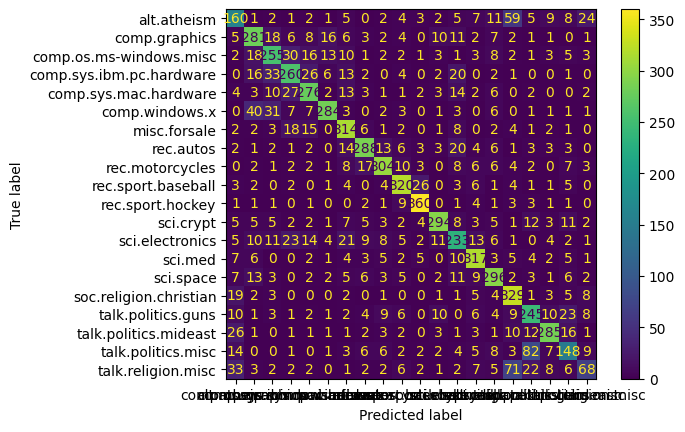

In [118]:
svm, X_train, X_test, cm, accuracy, y_test_pred = res[1]

_ = eval_classification_quality(y_test_pred,test_target,newsgroups_train.target_names, display)

In the confusion matrix and the classification report it is visible that the classifier is particularly struggling with correctly classifying the 'alt.atheism' and the talk categories. Note that the categories with the three lowest F1 scores are also the categories that contain the lowest number of documents. That could therefore be one reason for the bad performance in those categories. To adress this, we try a hierarchical learning approach.

The confusion matrix and classification report highlight that the classifier faces challenges in accurately classifying the 'alt.atheism' and 'talk' categories. Note that the categories with the three lowest F1 scores – 'talk.politics.misc', 'talk.religion.mics', and 'alt.atheism' – are also the categories that contain the lowest number of documents. That could therefore be one reason for the bad performance in those categories. 

We now try to improve the performance by using a hierarchical learning approach.

# 4. Trying a Hierarchical Learning Approach

We divide the learning process in two steps. In the first step, the model assigns texts to broader categories. In the second step, the exact category is determined.

## 4.1 Classification into broader categories

We aim to collect the categories in reasonable broader categories which can be well differentiated.

### 4.1.1. Categorization 1

With the above confusion matrix, the following observations can be made:

- talk.religion.misc often gets misclassified as soc.religion.christian.
- alt.atheism is often confused with soc.religion.christian.
- sci.electronics is commonly mistaken for the computer genre.
- The rec category shows accurate classification.

From these findings, we propose the following categorization:

    Category 1: alt.atheism, soc.religion.christian, talk genre
    Category 2: rec gerne, misc.forsale
    Category 3: computer genre, sci.electronics
    Category 4: rest of the science genre

#### Corresponding Labels:

- Category 1: 0, 15, 16-19
- Category 2: 6, 7-10
- Category 3: 1-5, 12
- Category 4: 11, 13-14

In [17]:
def categorization(labels, label_mapping):
    labels = [label_mapping[label] for label in labels]
    return labels

In [121]:
# Load the dataset
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

# Preprocess data
newsgroups_train.data, newsgroups_train.target  = preprocess(newsgroups_train.data, newsgroups_train.target)
newsgroups_test.data, newsgroups_test.target = preprocess(newsgroups_test.data, newsgroups_test.target)

label_mapping = {0: 1, 1: 3, 2: 3, 3:3, 4:3, 5:3, 6:2, 7:2, 8:2, 9:2, 10:2, 11:4, 12:3, 13:4, 14:4, 15:1, 16:1, 17:1, 18:1, 19:1}
newsgroups_train.target = categorization(newsgroups_train.target,label_mapping)
newsgroups_test.target = categorization(newsgroups_test.target,label_mapping)
category_names = ['talk, alt.atheism, soc.religion', 'rec, misc.forsale', 'computer & sci.electronics', 'rest science']

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Test Accuracy: 0.8637419707530408
Test Classification Report:
               precision    recall  f1-score   support

           1       0.86      0.91      0.88      1967
           2       0.87      0.85      0.86      1916
           3       0.86      0.91      0.88      2294
           4       0.89      0.70      0.78      1140

    accuracy                           0.86      7317
   macro avg       0.87      0.84      0.85      7317
weighted avg       0.86      0.86      0.86      7317



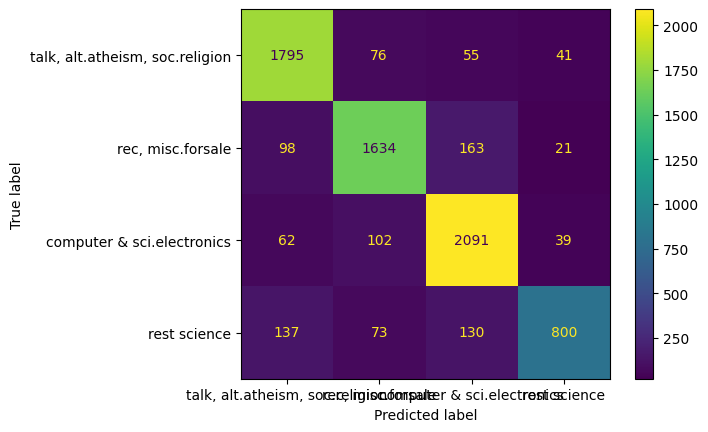

In [125]:
_ = try_svm(newsgroups_train.data, newsgroups_test.data, newsgroups_train.target, 
                                   newsgroups_test.target, category_names, display=True)

We see that the science category is performing worse than the others, likely due to having fewer documents available.
To address this issue, we propose merging the last category into other categories based on the initial confusion matrix:

- sci.crypt --> alt.atheism, soc.religion.christian, talk genre
- sci.med --> computer genre, sci.electronics
- sci.space --> computer gerne, sci.electronics

We obtain:
- Category 1: alt.atheism, soc.religion.christian, talk genre, sci.crypt
- Category 2: rec genre, misc.forsale
- Category 3: computer gerne, sci.electronics, sci.med, sci.space

### 4.1.2. Categorization 2

#### Corresponding Labels:

- Category 1: 0, 11, 15, 16-19
- Category 2: 6, 7-10
- Category 3: 1-5, 12, 13, 14

In [126]:
# Load the dataset
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

# Preprocess data
newsgroups_train.data, newsgroups_train.target  = preprocess(newsgroups_train.data, newsgroups_train.target)
newsgroups_test.data, newsgroups_test.target = preprocess(newsgroups_test.data, newsgroups_test.target)

label_mapping = {0: 1, 1: 3, 2: 3, 3:3, 4:3, 5:3, 6:2, 7:2, 8:2, 9:2, 10:2, 11:1, 12:3, 13:3, 14:3, 15:1, 16:1, 17:1, 18:1, 19:1}
newsgroups_train.target = categorization(newsgroups_train.target,label_mapping)
newsgroups_test.target = categorization(newsgroups_test.target,label_mapping)
category_names = ['alt.atheism, soc.religion, talk, sci.crypt', 'rec, misc.forsale', 'computer, sci.electronics, sci.med, sci.space']

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Test Accuracy: 0.8891622249555828
Test Classification Report:
               precision    recall  f1-score   support

           1       0.90      0.90      0.90      2347
           2       0.91      0.83      0.87      1916
           3       0.87      0.92      0.90      3054

    accuracy                           0.89      7317
   macro avg       0.89      0.88      0.89      7317
weighted avg       0.89      0.89      0.89      7317



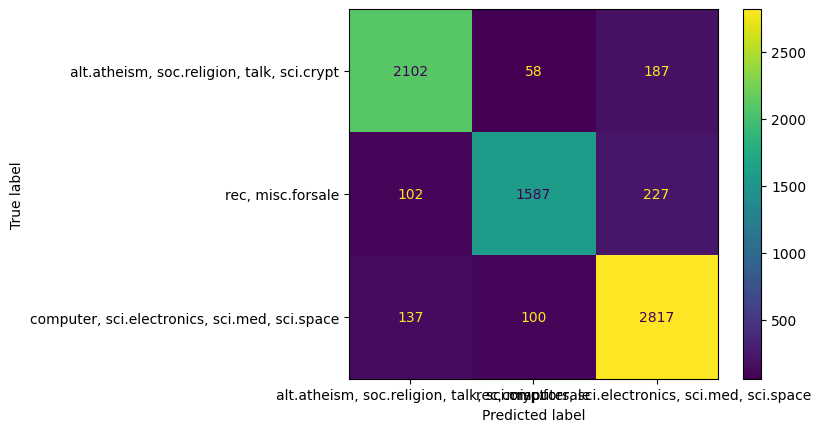

In [128]:
_ = try_svm(newsgroups_train.data, newsgroups_test.data, newsgroups_train.target,
                                   newsgroups_test.target, category_names, display=True)

## 4.2 Classification within the categories

Now we aim to construct three SVMs that are classifiying within these categories. 

In [18]:
def second_level_classifier(train_data, test_data, y_train, y_test, target_names, train_indexes, test_indexes, C=1, ngram_range=(1,2)):
    """
    This function trains multiple LinearSVC classifiers, one for classification in each defined category,
    and evaluates their performance on the corresponding test sets.
    """
    ngram_vectorizer = TfidfVectorizer(ngram_range=ngram_range)

    classifier = []
    accuracies = []

    for i in range(len(train_indexes)):

        # Fit and transform the training data
        train_data_np = np.array(train_data)
        test_data_np = np.array(test_data)
        
        X_train = ngram_vectorizer.fit_transform(train_data_np[train_indexes[i]])

        # Transform the test data
        X_test = ngram_vectorizer.transform(test_data_np[test_indexes[i]])

        # Initialize the SVM classifier
        svm = LinearSVC(C=C, random_state=42)

        # Train the classifier
        svm.fit(X_train, y_train[train_indexes[i]])

        classifier.append(svm)

        # Predict on the test set
        y_test_pred = svm.predict(X_test)
        accuracy = accuracy_score(y_test[test_indexes[i]], y_test_pred)
        accuracies.append(accuracy)
        print(f"Test Accuracy of Classifier {i+1}:", accuracy)
        print(f"Test Classification Report for Classifier {i+1}:\n", classification_report(y_test[test_indexes[i]], y_test_pred))
        
        # Generate confusion matrix
        cm = confusion_matrix(y_test[test_indexes[i]], y_test_pred)
        
        # Display the confusion matrix
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names[i])
        disp.plot()
        plt.show()

    return classifier, accuracies

In [156]:
# Load the dataset
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

# Preprocess data
newsgroups_train.data, newsgroups_train.target  = preprocess(newsgroups_train.data, newsgroups_train.target)
newsgroups_test.data, newsgroups_test.target = preprocess(newsgroups_test.data, newsgroups_test.target)

In [157]:
train_indexes_1 = (newsgroups_train.target == 0) | (newsgroups_train.target == 11) | (newsgroups_train.target >= 15)
train_indexes_2 = ((newsgroups_train.target >= 6) & (newsgroups_train.target <= 10))
train_indexes_3 = ~ (train_indexes_1 | train_indexes_2)
train_indexes = [train_indexes_1, train_indexes_2, train_indexes_3]

test_indexes_1 = (newsgroups_test.target == 0) | (newsgroups_test.target == 11) | (newsgroups_test.target >= 15)
test_indexes_2 = ((newsgroups_test.target >= 6) & (newsgroups_test.target <= 10))
test_indexes_3 = ~ (test_indexes_1 | test_indexes_2)
test_indexes = [test_indexes_1, test_indexes_2, test_indexes_3]

target_names_1 = ['alt.atheism', 'sci.crypt', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 
                  'talk.politics.misc', 'talk.religion.misc']
target_names_2 =  ['misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']
target_names_3 = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
                  'comp.windows.x', 'sci.electronics', 'sci.med', 'sci.space']
target_names = [target_names_1, target_names_2, target_names_3]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Test Accuracy of Classifier 1: 0.6885385598636558
Test Classification Report for Classifier 1:
               precision    recall  f1-score   support

           0       0.59      0.56      0.57       311
          11       0.87      0.85      0.86       380
          15       0.64      0.88      0.74       384
          16       0.61      0.74      0.66       354
          17       0.86      0.79      0.83       370
          18       0.65      0.52      0.58       303
          19       0.52      0.27      0.36       245

    accuracy                           0.69      2347
   macro avg       0.68      0.66      0.66      2347
weighted avg       0.69      0.69      0.68      2347



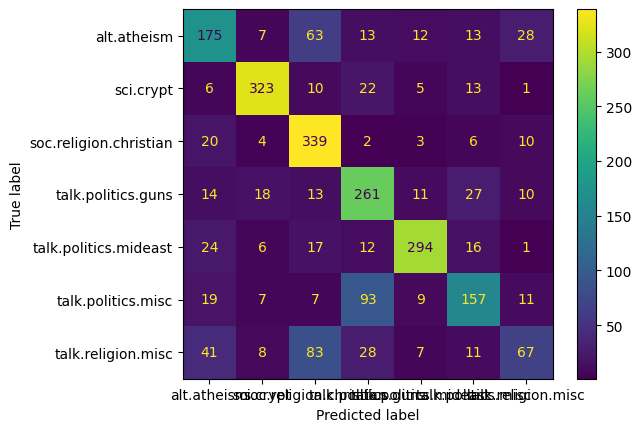

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Test Accuracy of Classifier 2: 0.877348643006263
Test Classification Report for Classifier 2:
               precision    recall  f1-score   support

           6       0.89      0.93      0.91       382
           7       0.84      0.84      0.84       375
           8       0.86      0.83      0.85       386
           9       0.88      0.86      0.87       383
          10       0.91      0.92      0.91       390

    accuracy                           0.88      1916
   macro avg       0.88      0.88      0.88      1916
weighted avg       0.88      0.88      0.88      1916



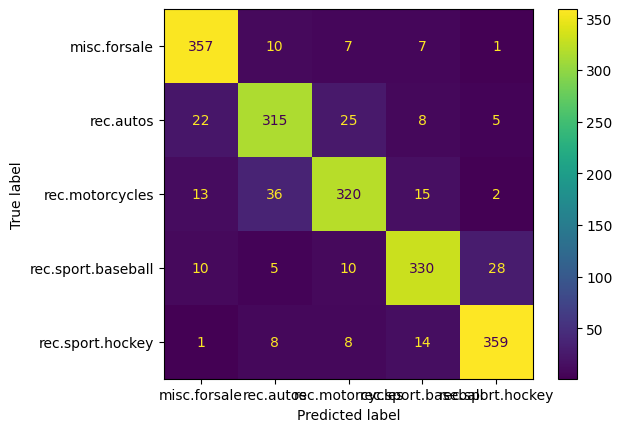

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Test Accuracy of Classifier 3: 0.7567125081859856
Test Classification Report for Classifier 3:
               precision    recall  f1-score   support

           1       0.70      0.76      0.73       384
           2       0.69      0.68      0.68       379
           3       0.71      0.69      0.70       386
           4       0.79      0.76      0.77       371
           5       0.81      0.73      0.77       391
          12       0.73      0.73      0.73       383
          13       0.82      0.90      0.86       382
          14       0.81      0.83      0.82       378

    accuracy                           0.76      3054
   macro avg       0.76      0.76      0.76      3054
weighted avg       0.76      0.76      0.76      3054



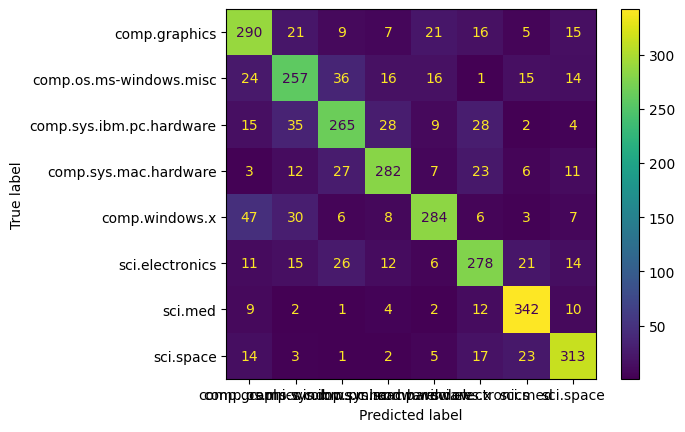

In [161]:
classifiers, accuracies = second_level_classifier(newsgroups_train.data, newsgroups_test.data, newsgroups_train.target, newsgroups_test.target,
                        target_names, train_indexes, test_indexes, C=1, ngram_range=(1,2))

In [169]:
print('Accuracies:')
print("Classifier 1: {:.2f}%".format(accuracies[0]*100))  
print("Classifier 2: {:.2f}%".format(accuracies[1]*100))
print("Classifier 3: {:.2f}%".format(accuracies[2]*100))

Accuracies:
Classifier 1: 68.85%
Classifier 2: 87.73%
Classifier 3: 75.67%


The accuracy of each classifier highlights the varying difficulty of classifying different categories. Classifying topics within the 'talk' genre and 'alt.atheism' remains particularly challenging, as well as within the 'computer' genre. Conversely, classification within the 'rec' genre demonstrates notably strong performance.

## 4.3 Combining Both Steps into one Classification model

In [18]:
def categorization(labels, label_mapping):
    labels = [label_mapping[label] for label in labels]
    return labels

In [19]:
def hierarchical_classifier(train_data, test_data, y_train, train_indexes, cat_test_pred, C=1 ,ngram_range=(1,2)):
    """
    This function trains multiple LinearSVC classifiers in a hierarchical manner based on the predictions of a
    first layer classifier. It returns a list of used classifiers in the first step and the final predicted labels
    after hierarchical classification.
    """
    ngram_vectorizer = TfidfVectorizer(ngram_range=ngram_range)
    classifier = []

    # Initialize subcategories array
    y_test_final_pred = np.zeros_like(cat_test_pred)

    # Create masks
    mask_1 = (cat_test_pred == 1)
    mask_2 = (cat_test_pred == 2)
    mask_3 = (cat_test_pred == 3)
    masks = [mask_1,mask_2,mask_3]

    # Initialize the SVM classifier
    svm = LinearSVC(C=C, random_state=42)

    for i in range(len(train_indexes)):
        
        # Fit and transform the training data
        train_data_masked = itertools.compress(train_data,train_indexes[i])
        test_data_masked = itertools.compress(test_data,masks[i])

        X_train = ngram_vectorizer.fit_transform(train_data_masked)
        X_test = ngram_vectorizer.transform(test_data_masked)

        # Train the classifier
        svm.fit(X_train, y_train[train_indexes[i]])

        y_test_second_layer = svm.predict(X_test)
        y_test_final_pred[masks[i]] = y_test_second_layer

        classifier.append(svm)

    return classifier, y_test_final_pred

In [144]:
# Load the dataset
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

# Preprocess data
newsgroups_train.data, newsgroups_train.target  = preprocess(newsgroups_train.data, newsgroups_train.target)
newsgroups_test.data, newsgroups_test.target = preprocess(newsgroups_test.data, newsgroups_test.target)

train_indexes_1 = (newsgroups_train.target == 0) | (newsgroups_train.target == 11) | (newsgroups_train.target >= 15)
train_indexes_2 = ((newsgroups_train.target >= 6) & (newsgroups_train.target <= 10))
train_indexes_3 = ~ (train_indexes_1 | train_indexes_2)
train_indexes = [train_indexes_1, train_indexes_2, train_indexes_3]

test_indexes_1 = (newsgroups_test.target == 0) | (newsgroups_test.target == 11) | (newsgroups_test.target >= 15)
test_indexes_2 = ((newsgroups_test.target >= 6) & (newsgroups_test.target <= 10))
test_indexes_3 = ~ (test_indexes_1 | test_indexes_2)
test_indexes = [test_indexes_1, test_indexes_2, test_indexes_3]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto

Test Accuracy: 0.7006970069700696
Test Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.52      0.51       311
           1       0.65      0.75      0.70       384
           2       0.64      0.66      0.65       379
           3       0.63      0.67      0.65       386
           4       0.71      0.74      0.72       371
           5       0.79      0.72      0.75       391
           6       0.75      0.74      0.75       382
           7       0.81      0.67      0.73       375
           8       0.84      0.71      0.77       386
           9       0.86      0.78      0.82       383
          10       0.90      0.88      0.89       390
          11       0.82      0.72      0.77       380
          12       0.56      0.64      0.60       383
          13       0.73      0.78      0.76       382
          14       0.67      0.74      0.70       378
          15       0.62      0.85      0.72       384
          16      

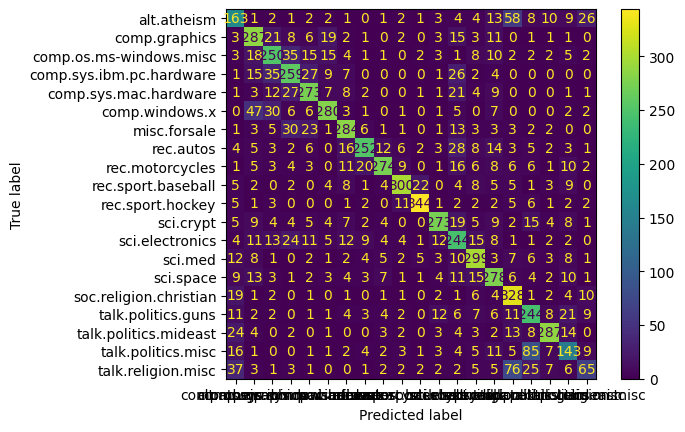

In [178]:
# Mapping of original labels to new categories
label_mapping = {0: 1, 1: 3, 2: 3, 3: 3, 4: 3, 5: 3, 6: 2, 7: 2, 8: 2, 9: 2, 10: 2, 11: 1, 12: 3, 13: 3, 14: 3, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1}

# Definition of broader category names
category_names = ['alt.atheism, soc.religion, talk, sci.crypt', 'rec, misc.forsale', 'computer, sci.electronics, sci.med, sci.space']

# Categorize training and test data using the label mapping
cat_train = categorization(newsgroups_train.target, label_mapping)
cat_test = categorization(newsgroups_test.target, label_mapping)

# Train an SVM model with the broader categories as targets
model, _, X_test, *_ = try_svm(newsgroups_train.data, newsgroups_test.data, cat_train, cat_test, category_names)

# Predict broader categories for test data using the trained model
cat_pred_test = model.predict(X_test)

# Apply hierarchical classification on training and test data
classifier, y_test_final_pred = hierarchical_classifier(newsgroups_train.data, newsgroups_test.data, newsgroups_train.target, train_indexes, cat_pred_test)

# Evaluate classification quality and display confusion matrix
cm, accuracy_hierarchical = eval_classification_quality(y_test_final_pred, newsgroups_test.target, newsgroups_train.target_names, display=True)


In [179]:
print("Accuracy of the hierarchical model: {:.2f}%".format(accuracy_hierarchical*100))

Accuracy of the hierarchical model: 70.07%


Compared to an accuracy of 72.67% in the initial non-hierarchical approach, the hierarchical model shows a slightly lower performance with 70.07%. Upon closer inspection, the confusion matrices of both models appear quite similar. 

We conclude that dividing the learning process in this manner does not yield improved performance. The inherent classification challenges persisted, resulting in no discernible benefit.

# 5. Classification Using Neural Networks

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

from tensorflow import keras
import tensorflow.keras.layers as layers
from scikeras.wrappers import KerasClassifier

from sklearn.decomposition import TruncatedSVD

In [20]:
def create_model(n,p,layer_sizes):
    '''
    Function which takes number of classes to classify n, dropout rate p and a tuple of layer_sizes to return a NN
    with hidden layers as given.
    '''
    model = keras.models.Sequential()
    model.add(layers.Flatten())
    for i in layer_sizes:
        model.add(layers.Dense(i, activation='relu'))
        model.add(layers.Dropout(p))
    model.add(layers.Dense(n,activation='softmax'))
    return model

def try_nn(train_data,test_data,y_train,y_test,target_names,p=0.7,Ks=128,epochs=20,layer_sizes=[100,],
           n_pca=None,ngram_range=(1,1)):
    ''' 
    Builds and tests for given preprocessed data a Neural Network with given parameters, if n_pca is an integer, a
    PCA is done in advance.
    '''
    n_cat = len(target_names)
    ngram_vectorizer = TfidfVectorizer(ngram_range=ngram_range)

    # Fit and transform the training data
    X_train = ngram_vectorizer.fit_transform(train_data)

    # Transform the test data
    X_test = ngram_vectorizer.transform(test_data)

    y_train = keras.utils.to_categorical(y_train, n_cat)
    y_test = keras.utils.to_categorical(y_test, n_cat)
    
    if n_pca:
        print('Do PCA analysis for training data ...')
        pca = TruncatedSVD(n_components=n_pca,algorithm='arpack',)
        X_train = pca.fit_transform(X_train)
        print('Do PCA analysis for test data ...')
        X_test = pca.transform(X_test)
    
    print('Train NN ...')
    model = create_model(n_cat,p=p,layer_sizes=layer_sizes)

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    history = model.fit(X_train, y_train, batch_size=Ks, epochs=epochs, 
                    validation_data=(X_test,y_test), verbose=False)
    
    return model, history, X_test
   

#### With ngram_range = (1,2)

In [21]:
# Load the dataset
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

# Preprocess data
newsgroups_train.data, newsgroups_train.target  = preprocess(newsgroups_train.data, newsgroups_train.target)
newsgroups_test.data, newsgroups_test.target = preprocess(newsgroups_test.data, newsgroups_test.target)

In [22]:
import time
t = time.time()
model, history, X_test = try_nn(newsgroups_train.data,newsgroups_test.data, newsgroups_train.target, 
                                newsgroups_test.target,newsgroups_train.target_names,ngram_range=(1,2))
print(t-time.time())
y_test_predict = model.predict(X_test)
y_test_predict = np.argmax(y_test_predict,axis=1)

Train NN ...
-991.485481262207
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


Test Accuracy: 0.7358206915402488
Test Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.52      0.56       311
           1       0.54      0.83      0.65       384
           2       0.68      0.67      0.67       379
           3       0.70      0.64      0.67       386
           4       0.76      0.76      0.76       371
           5       0.87      0.72      0.79       391
           6       0.78      0.80      0.79       382
           7       0.82      0.79      0.80       375
           8       0.81      0.79      0.80       386
           9       0.93      0.88      0.90       383
          10       0.94      0.92      0.93       390
          11       0.89      0.74      0.81       380
          12       0.68      0.61      0.64       383
          13       0.86      0.80      0.83       382
          14       0.86      0.78      0.82       378
          15       0.63      0.88      0.73       384
          16      

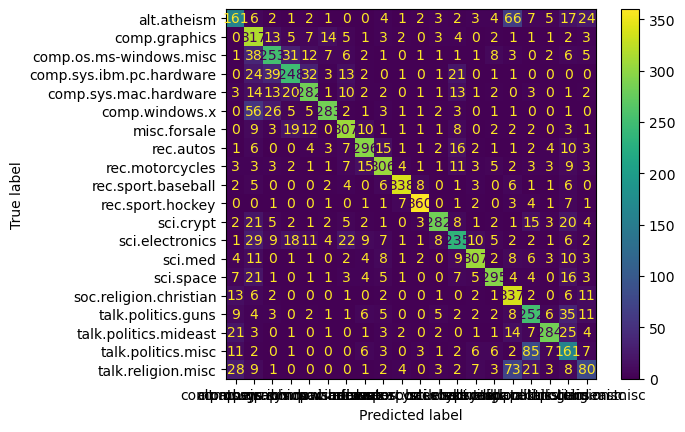

In [23]:
_ = eval_classification_quality(y_test_predict,newsgroups_test.target,newsgroups_train.target_names, display=True)

#### With ngram_range = (1,1)

One can see that the accuracy does not really improves when using ngram_range=(1,2) but the runtime increases so we decided to use just single words for classification.

In [24]:
t = time.time()
model, history, X_test = try_nn(newsgroups_train.data,newsgroups_test.data, newsgroups_train.target, 
                                newsgroups_test.target,newsgroups_train.target_names,ngram_range=(1,1))
print(t-time.time())
y_test_predict = model.predict(X_test)
y_test_predict = np.argmax(y_test_predict,axis=1)

Train NN ...
-111.8897557258606
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Test Accuracy: 0.7336340030066968
Test Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.59      0.56       311
           1       0.68      0.76      0.71       384
           2       0.65      0.66      0.66       379
           3       0.63      0.70      0.67       386
           4       0.75      0.78      0.76       371
           5       0.86      0.71      0.78       391
           6       0.76      0.77      0.77       382
           7       0.74      0.81      0.77       375
           8       0.82      0.79      0.81       386
           9       0.88      0.89      0.88       383
          10       0.94      0.92      0.93       390
          11       0.86      0.76      0.81       380
          12       0.63      0.63      0.63       383
          13       0.85      0.80      0.82       382
          14       0.82      0.79      0.81       378
          15       0.70      0.80      0.75       384
          16      

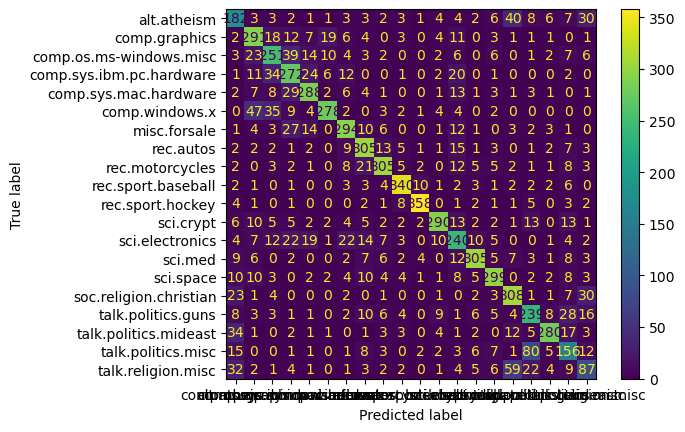

In [25]:
_ = eval_classification_quality(y_test_predict,newsgroups_test.target,newsgroups_train.target_names, display=True)

# 6. Hyperparameter Tuning

### SVC Tuning

We used the pre-build pipeline of sklearn to get insight on the best maginitude of the parameter C for SCVs. We then used this C for all SVCs.

In [46]:
# Load the dataset
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

# Preprocess data
newsgroups_train.data, newsgroups_train.target  = preprocess(newsgroups_train.data, newsgroups_train.target)
newsgroups_test.data, newsgroups_test.target = preprocess(newsgroups_test.data, newsgroups_test.target)

In [47]:
# Create an SVM model
svm = LinearSVC(kernel='linear', random_state=42)

# Create a pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),  # Step 1: Convert text to TF-IDF features
    ('svm', svm)                                       # Step 2: Train SVM classifier
])

# Define the range of C values to test
param_grid = {
    'svm__C': [ 0.01, 0.1, 1, 10, 100] , # Grid search over the C parameter of SVM
}

# Use GridSearchCV to find the best parameter C
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring='accuracy')

# Fit the model to the training data
grid_search.fit(newsgroups_train.data, newsgroups_train.target)

# Print the best parameter C and the corresponding score
print("Best parameter C:", grid_search.best_params_['svm__C'])
print("Best cross-validation score:", grid_search.best_score_)

# Evaluate the model on the test data
best_model = grid_search.best_estimator_
test_score = best_model.score(newsgroups_test.data, newsgroups_test.target)
print("Test set score:", test_score)

Best parameter C: 1
Best cross-validation score: 0.755226930400432
Test set score: 0.6891451831750339


### NN tuning without PCA 

Hyperparameter tuning for our Neural Network architecture, we tuned the parameters dropout probability and the layer sizes and did not used PCA analysis. We then used the best parameters for the above calculations and presumed that they work well for both ngram ranges.

In [27]:
def tune_hyperparameter_nn(train_data,test_data,y_train,y_test,target_names,
                           ps=[0,0.5],Kss=[128],epochss=[20],layer_sizess=[(100,)],n_pcas=[None]):
    names = ['Dropout probability','Batch size','Epochs','layer sizes','number of PCs']
    
    parameters = {i:0 for i in itertools.product(ps,Kss,epochss,layer_sizess,n_pcas)}
    #print(parameters)
    for p,Ks,epochs,layer_sizes,n_pca in itertools.product(ps,Kss,epochss,layer_sizess,n_pcas):
        # Compute model with current hyperparameters
        print('Current parameters:',{label:value for label,value in zip(names,[p,Ks,epochs,layer_sizes,n_pca ])})
        t = time.time()
        model, history, X_test = try_nn(train_data,test_data,y_train,y_test,target_names,
                                        p=p,Ks=Ks,epochs=epochs,layer_sizes=layer_sizes,n_pca=n_pca)
        print(time.time()-t)
        # Predict labels for test data
        y_test_predict = model.predict(X_test)
        y_test_predict = np.argmax(y_test_predict,axis=1)

        #C_matrix, accuracy = compute_con_matrix(data, y_test_predict)
        C_matrix, accuracy = eval_classification_quality(y_test_predict,y_test,target_names)
        print('The accuracy is:',accuracy)
        parameters[p,Ks,epochs,layer_sizes,n_pca] = accuracy
        
    best_parameters = max(parameters, key=parameters.get)
    labels = {label:value for label,value in zip(names,best_parameters)}
    print('The best parameters found are',labels)
    return labels

In [51]:
labels = tune_hyperparameter_nn(newsgroups_train.data,newsgroups_test.data, newsgroups_train.target, 
                                newsgroups_test.target,newsgroups_train.target_names,
                                ps=[0.5,0.7,0.95],layer_sizess=[(100,),(200,),(100,100),(50,50)])  

Current parameters: {'Dropout probability': 0.5, 'Batch size': 128, 'Epochs': 20, 'layer sizes': (100,), 'number of PCs': None}
Train NN ...
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
The accuracy is: 0.7350006833401668
Current parameters: {'Dropout probability': 0.5, 'Batch size': 128, 'Epochs': 20, 'layer sizes': (200,), 'number of PCs': None}
Train NN ...
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
The accuracy is: 0.7299439661063277
Current parameters: {'Dropout probability': 0.5, 'Batch size': 128, 'Epochs': 20, 'layer sizes': (100, 100), 'number of PCs': None}
Train NN ...
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
The accuracy is: 0.7131337980046467
Current parameters: {'Dropout probability': 0.5, 'Batch size': 128, 'Epochs': 20, 'layer sizes': (50, 50), 'number of PCs': None}
Train NN ...
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
The accuracy is: 0.6990569905699057
Current parameters: {'Dropout probability': 0.7, 'Batch size': 128, 'Epochs': 20, 'layer sizes': (100,), 'number of PCs': 

The above analysis suggests that one hidden layer performs better than two hidden layers. The dropout probability does not seem to have a large influence but the last two iterations imply that it is important to include some. We take dropout rate 0.7 and one hidden layer with 100 neurons for the other calculations.

### NN tuning, try to use pca

In [28]:
labels = tune_hyperparameter_nn(newsgroups_train.data,newsgroups_test.data, newsgroups_train.target, 
                                newsgroups_test.target,newsgroups_train.target_names,n_pcas = [500,1000,2000],
                                layer_sizess=[(100,)])  

Current parameters: {'Dropout probability': 0, 'Batch size': 128, 'Epochs': 20, 'layer sizes': (100,), 'number of PCs': 500}
Do PCA analysis for training data ...
Do PCA analysis for test data ...
Train NN ...
49.2820143699646
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
The accuracy is: 0.6735000683340167
Current parameters: {'Dropout probability': 0, 'Batch size': 128, 'Epochs': 20, 'layer sizes': (100,), 'number of PCs': 1000}
Do PCA analysis for training data ...
Do PCA analysis for test data ...
Train NN ...
164.15674877166748
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
The accuracy is: 0.6785567855678557
Current parameters: {'Dropout probability': 0, 'Batch size': 128, 'Epochs': 20, 'layer sizes': (100,), 'number of PCs': 2000}
Do PCA analysis for training data ...
Do PCA analysis for test data ...
Train NN ...
552.6686005592346
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
The accuracy is: 0.6771901052343857
Current parameters: {'Dropout probability': 0.5, 'Batch size': 128, 'Epochs': 20,

Finding: PCA analysis does not manage to extract the meaning of the text as well as the NN without PCA does but training is 
faster.

# 7. Insights on Misclassified Data

### Print average and median length of all test data and the missclassified ones

In [12]:
def average_word_count(X, targets, n_cat, where=None):
    '''
    Counts the number of words for all texts and computes the average and median length of the different categories.
    '''
    NoneType = type(None)
    if type(where) == NoneType:
        where = np.ones(len(targets))
    category_lengths = {i: [] for i in range(n_cat)}
    num_mc = {i:0 for i in range(n_cat)}
    
    for text, target, w in zip(X, targets, where):
        if w:
            num_mc[target] += 1
            category_lengths[target].append(len(text.split()))
    
    avg_lengths = {category: np.mean(lengths) for category, lengths in category_lengths.items()}
    median_lengths = {category: np.median(lengths) for category, lengths in category_lengths.items()}
    
    return avg_lengths, median_lengths, num_mc

def get_false_classified_avg(X_test,y,y_test_pred,target_names,average=True):
    '''
    Computes either average or median lenght of the texts per category for the whole test data set and then for the 
    missclassified texts. The results are ploted and the number at each bar displays the overall number of texts over which
    the average/median was computed. 
    '''
    n_cat = len(target_names)

    # Compute average length of test dataset and the missclassified data
    where = np.not_equal(y,y_test_pred)
    avg_length, median_lengths, number  = average_word_count(X_test,y,n_cat)
    avg_length_mc, median_lengths_mc, number_mc = average_word_count(X_test,y,n_cat,where=where)
    
    # Plot the lengths
    fig, ax = plt.subplots(figsize=(6,10))
     
    X = np.arange(n_cat)
    
    # Plot average of all test data and missclassified ones
    if average:
        b1 = ax.barh(X+0.2, list(avg_length.values()),label='All mean',height=0.4)
        b2 = ax.barh(X-0.2, list(avg_length_mc.values()),label='Missclassified mean',height=0.4)
    
    else:
        b1 = ax.barh(X+0.2, list(median_lengths.values()),label='All median',height=0.4)
        b2 = ax.barh(X-0.2, list(median_lengths_mc.values()),label='Missclassified median',height=0.4)
    
    # Print number of test data / missclassified test data to corresponding bars
    #ax.bar_label(b1, labels = number.values())
    #ax.bar_label(b2, labels = number_mc.values())
    ax.set_yticks(X , target_names)
    
    if average:
        ax.set_title('Average Word Count')
        ax.set_ylabel('Average Document Length')
    else:
        ax.set_title('Median Word Count')
        ax.set_ylabel('Median Document Length')
        
    ax.set_xlabel('Categories')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0,title='Test data with quantity of each category')
 
    plt.show()

def get_false_classified_examples(X_test,y,y_test_pred,target_names,n=10):
    '''
    Prints n many false classified texts which are chosen randomly.
    '''
    where = np.equal(y,y_test_pred)
    ints = np.ma.masked_array(np.arange(len(y)),mask=where)

    # Print n many examples of missclassified texts
    print('Examples of missclassified test data:')
    rng = np.random.default_rng()
    indices = rng.choice(ints,size=n,replace=False)
    for i in indices:
        idx = y[i]
        print()
        print(idx, target_names[idx])
        print(X_test[i])
     

#### Average and median number of test text and missclassified test texts, classification done with SVM

In [13]:
# Load the dataset
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

# Preprocess data, do not use stop words and stemming to get reasonable texts
newsgroups_train.data, newsgroups_train.target  = preprocess(newsgroups_train.data, newsgroups_train.target)
newsgroups_test.data, newsgroups_test.target = preprocess(newsgroups_test.data, newsgroups_test.target)

In [14]:
# Train SVC
model, X_train, X_test, _, _, _ = try_svm(newsgroups_train.data, newsgroups_test.data, newsgroups_train.target, 
                                                 newsgroups_test.target, newsgroups_train.target_names)

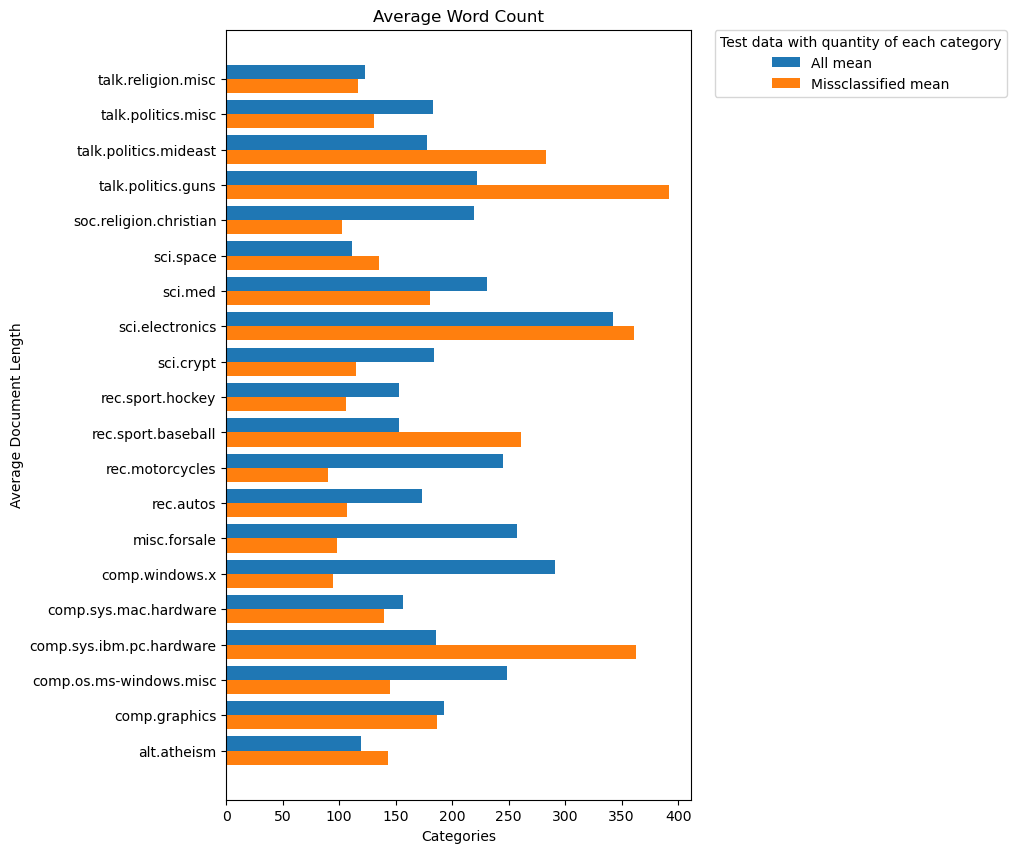

In [15]:
y_test_pred = model.predict(X_test)
get_false_classified_avg(newsgroups_train.data,newsgroups_test.target,y_test_pred,newsgroups_train.target_names)

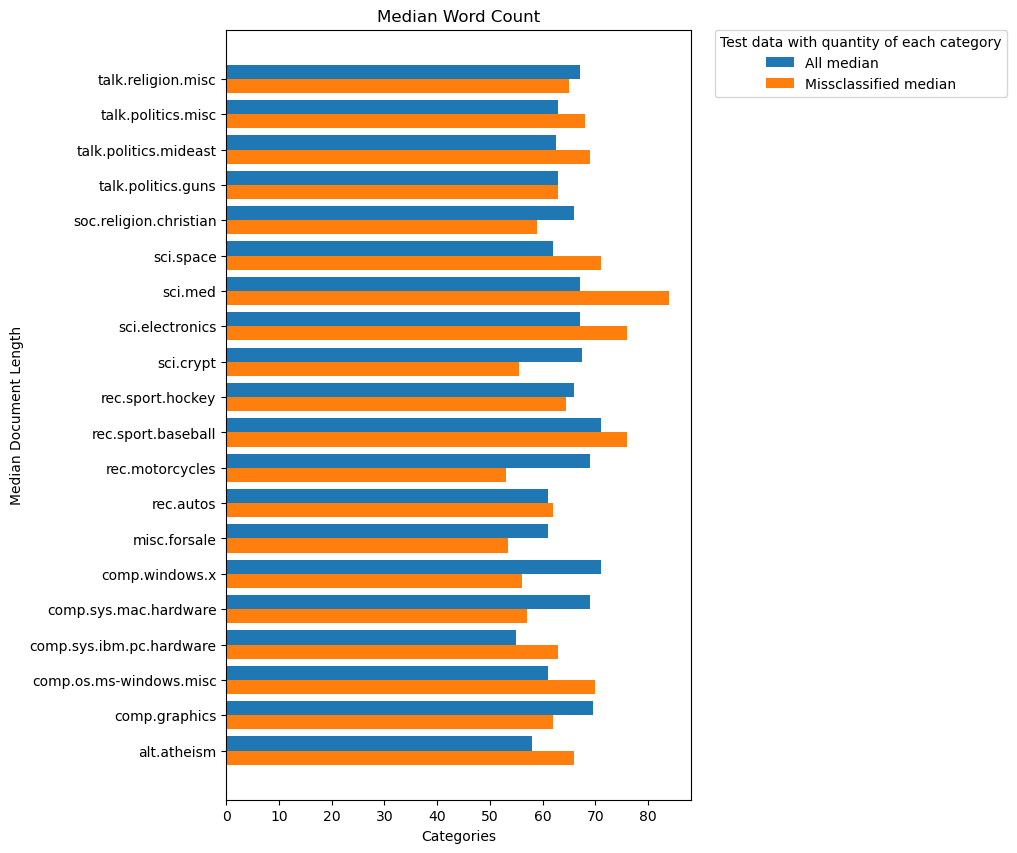

In [16]:
get_false_classified_avg(newsgroups_train.data,newsgroups_test.target,y_test_pred,newsgroups_train.target_names,
                         average=False)

The first thing to notice is that there are several very long texts which make the average text size much longer than the median text size. It does not seem as if the length of the texts plays a role in missclassification with SVMs, for some classes longer texts are missclassified and for other classes the shorter texts. 

#### Median number of test text and missclassified test texts, classification done with NNs

In [60]:
# Train NN
model, history, X_test = try_nn(newsgroups_train.data,newsgroups_test.data, newsgroups_train.target, 
                                newsgroups_test.target,newsgroups_train.target_names)

Train NN ...


229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


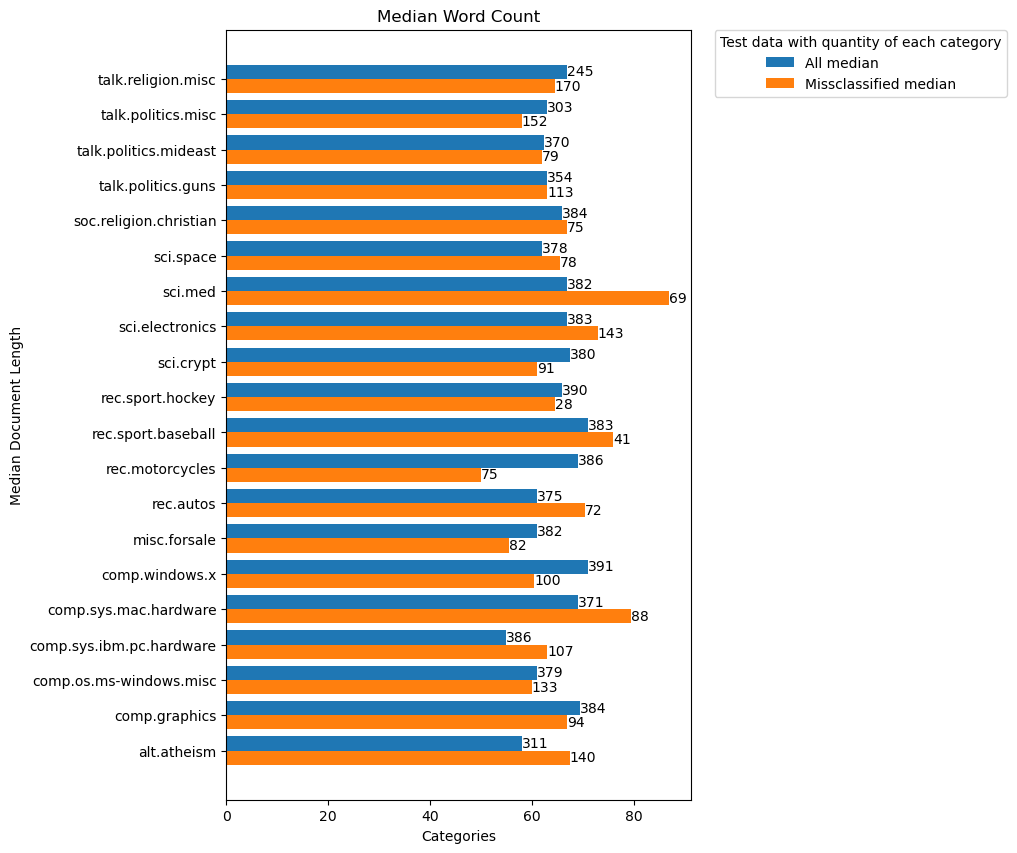

In [62]:
y_test_pred = model.predict(X_test)
y_test_pred = np.argmax(y_test_pred,axis=1)

get_false_classified_avg(newsgroups_train.data,newsgroups_test.target,y_test_pred,newsgroups_train.target_names,
                         average=False)

One can see that the results for the classification with NNs are quite similar. For example in category sci.med the long texts are missclassified more often than the short ones and this finding does not really depends on the chosen classifier. This strengthens our guess that the same texts are missclassified.

#### Print examples of false classified texts

In [29]:
# Download the test data another times
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

# Preprocess data, do not use stop words and stemming to get reasonable texts
newsgroups_train.data, newsgroups_train.target  = preprocess(newsgroups_train.data, newsgroups_train.target,
                                                             rm_stop_words = False, use_stemming = False)
newsgroups_test.data, newsgroups_test.target = preprocess(newsgroups_test.data, newsgroups_test.target,
                                                          rm_stop_words = False, use_stemming = False)

# Train SVC
model, X_train, X_test, cm, _, _, vectorizer = try_svm(newsgroups_train.data, newsgroups_test.data, newsgroups_train.target, 
                                                 newsgroups_test.target, newsgroups_train.target_names, long_out=True)

y_test_pred = model.predict(X_test)


In [30]:
get_false_classified_examples(newsgroups_train.data,newsgroups_test.target,y_test_pred,newsgroups_train.target_names)

Examples of missclassified test data:

2 comp.os.ms-windows.misc
aw&st  had a brief blurb on a manned lunar exploration confernce
may 7th  at crystal city virginia, under the auspices of aiaa.

does anyone know more about this?  how much, to attend????

anyone want to go?

2 comp.os.ms-windows.misc


what i've been saying is that moral behavior is likely the null behavior.
that is, it doesn't take much work to be moral, but it certainly does to
be immoral (in some cases).  also, i've said that morality is a remnant
of evolution.  our moral system is based on concepts well practiced in
the animal kingdom.


but, this doesn't get us anywhere.  your particular beliefs are irrelevant
unless you can share them or discuss them...

2 comp.os.ms-windows.misc
r >>>jd> all pc parallel ports that are compatable with the ibm standard,
r >>>jd> including the original ibm adaptor, are bi-directional.

not all parallel ports are bi-directional without modification.

my experience with the standard ol

In [50]:
get_false_classified_examples(newsgroups_train.data,newsgroups_test.target,y_test_pred,newsgroups_train.target_names)

Examples of missclassified test data:

4 comp.sys.mac.hardware


so how much would it cost as a private venture, assuming you could talk the
u.s. government into leasing you a couple of pads in florida? 



17 talk.politics.mideast

well, if you want to pick on morgan, why not attack its ash (wood)
frame or its hand-bent metal skin (just try and get a replacement :-)).  
i thought the kingpost suspension was one of the mog's better features.

18 talk.politics.misc
#
# i remember seeing something in the x distribution mentioning support
# for a tektronix terminal in an x server.  is this accurate? 
#

xterm supports 401x emulation.


patrick l. mahan

--- tgv window washer ------------------------------- mahan@tgv.com ---------

16 talk.politics.guns

i think you may be chasing the wrong problem.  i don't think it is the
function overloading at all-- i do that sort of thing all of the time
in bc++ without a hitch.  the big problems i have encountered in
porting mfc to bc++ is that fact 

One can see that several of them are quite difficult to classify in one of the 
categories if one reads them especially some of the short ones could be in many classes.

### Print the words with the largest coefficients found by the SVM, so the most important words 

In [67]:
import itertools
import pprint

def print_main_words(model,target_names,vectorizer,n_words=10,Lin_SVM=True):
    '''
    Prints for each pair of categories the most important words for their distinction (n_words many)
    The number behind them gives the coefficient of the corresponding word.
    Lin_SVC is True if LinearSVM is used and False if SVC is used as classification.
    '''
    
    coef = model.coef_
    words = vectorizer.get_feature_names_out()
    
    if not Lin_SVM:
        iterator = itertools.combinations(target_names,2)
    else: 
        iterator = target_names
        
    for names,i in zip(iterator,range(coef.shape[0])):
        print(names)
        maximum = []
        max_values = []
        c = coef[i,:]
        for j in range(n_words):
            maxi = c.max()
            mini = c.min()
            m = max(abs(maxi),abs(mini))
            if m == maxi:
                argm = c.argmax()
            else:
                argm = c.argmin()
            maximum.append(words[argm])
            max_values.append(m)
            if not Lin_SVM:
                c[0,argm] = 0
            else:
                c[argm] = 0
            
        pprint.pprint([a+' '+str(b) for a,b in zip(maximum,max_values)])
        print()

In [64]:
# Load the dataset
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

# Preprocess data, do not use stop words and stemming to get reasonable texts
newsgroups_train.data, newsgroups_train.target  = preprocess(newsgroups_train.data, newsgroups_train.target)
newsgroups_test.data, newsgroups_test.target = preprocess(newsgroups_test.data, newsgroups_test.target)

#### LinearSVC 
We first do it with LinearSVC which learns a single hyperplane for each category which seperates this from all other categories. 

In [65]:
# Train SVC
model, X_train, X_test, cm, _, _, vectorizer = try_svm(newsgroups_train.data, newsgroups_test.data, 
                                                       newsgroups_train.target,  newsgroups_test.target, 
                                                       newsgroups_train.target_names, long_out=True)

In [68]:
print_main_words(model,newsgroups_train.target_names,vectorizer)

(20, 908904)
alt.atheism
['speci 1.141309603968808',
 'just up 1.139404983602576',
 'cheer kent 1.1033870172014255',
 'defin 1.0640420449073913',
 'religi 1.0414904252891344',
 'is 0.998608649790257',
 'bsa 0.9894916495505973',
 'omnipot 0.9848655916152038',
 'must 0.9814085480535245',
 'liar 0.9764594611299832']

comp.graphics
['68070 1.4876269299011733',
 'anim 1.459795926795963',
 'format 1.4495949281866936',
 '3do 1.3960751783990535',
 'vesa 1.3834245949500896',
 'graphics 1.3525186527648254',
 'librari 1.3169041528747856',
 'fractal 1.2949599006490384',
 'point 1.2889026944664659',
 'curv 1.265372637026478']

comp.os.ms-windows.misc
['risc 1.4341261996681618',
 'w4wg 1.4132933634574196',
 'icon 1.3740772243551411',
 'ax 1.2988835812604822',
 'ax ax 1.239227878416319',
 'ms 1.216851408035414',
 'download 1.1914561656244829',
 'chri 1.18498319634224',
 'it there 1.1758033059572452',
 'mine them 1.1391789880081369']

comp.sys.ibm.pc.hardware
['irq 1.6072691205529204',
 'isa 1.5336560

#### SVC
Training with the other implementation of SVC in sklearn, so the standard SVC with kernel='linear'. This classifier learns a hyperplane for each pair of categories, so quite a lot of pairs but the words found give some interesting insights. Most of the words are not surprising that they appear in one text category and not in others.

In [73]:
# Train SVC
model, X_train, X_test, cm, _, _, vectorizer = try_svm(newsgroups_train.data, newsgroups_test.data, 
                                                       newsgroups_train.target,  newsgroups_test.target, 
                                                       newsgroups_train.target_names, long_out=True,Linear_SVC=False)

In [75]:
print_main_words(model,newsgroups_train.target_names,vectorizer,Lin_SVM=False)

(190, 908904)
('alt.atheism', 'comp.graphics')
['imag 1.8557628938817305',
 'graphic 1.7859918070525256',
 'religion 1.6559093958490672',
 'file 1.621323988482398',
 'god 1.5923854608231665',
 'thank 1.560185293771338',
 'islam 1.4868550398601301',
 'moral 1.4559846135110772',
 'peopl 1.4132135839604085',
 'use 1.365843728477287']

('alt.atheism', 'comp.os.ms-windows.misc')
['window 3.2187129425238794',
 'file 2.0214089078400423',
 'use 1.9765910414966632',
 'religion 1.4934041844685115',
 'god 1.4025980055950114',
 'mail 1.34861715663704',
 'driver 1.3356525793750031',
 'islam 1.2497144758229297',
 'program 1.2490237491472391',
 'problem 1.2465498142639724']

('alt.atheism', 'comp.sys.ibm.pc.hardware')
['card 1.7752019881737606',
 'pc 1.6091307384671738',
 'drive 1.5995722059176594',
 'monitor 1.5548442212378408',
 'thank 1.5502363809972795',
 'religion 1.4786520887998658',
 'god 1.4720757225934673',
 'islam 1.333884435075642',
 'use 1.3128821214582227',
 'disk 1.2820587123378837']

(

['key 2.500908573932945',
 'encrypt 2.3270310801605083',
 'imag 2.202141916909761',
 'graphic 1.9915878213922065',
 'clipper 1.8561316204398695',
 'govern 1.6883301194283364',
 'thank 1.6192676674511803',
 'secur 1.594887612167842',
 'nsa 1.584045747220961',
 '3d 1.3385133270956349']

('comp.graphics', 'sci.electronics')
['imag 2.7010981629956334',
 'graphic 2.497240907762353',
 'file 2.171525386817792',
 'circuit 1.911160175340944',
 '3d 1.7511626685550814',
 'power 1.5556261557283166',
 'program 1.4972706977106898',
 'polygon 1.4250985070983588',
 'electron 1.3315007920011241',
 'point 1.2957079267483556']

('comp.graphics', 'sci.med')
['graphic 2.034457409768763',
 'file 1.9861084919022862',
 'imag 1.9737018941832123',
 'program 1.418958592896745',
 'doctor 1.4172778184239816',
 'diseas 1.4067425207554056',
 '3d 1.3852201273285805',
 'medic 1.3233556324748017',
 'comput 1.2891071352929677',
 'msg 1.2873846941219405']

('comp.graphics', 'sci.space')
['space 2.816618143341408',
 'grap

['card 2.0156824619527725',
 'drive 1.8638678344529824',
 'monitor 1.7716998511761348',
 'pc 1.739374453926835',
 'disk 1.4786149783613234',
 'medic 1.437425174009934',
 'comput 1.3540228196758677',
 'motherboard 1.3460629927351828',
 'doctor 1.2864473163626575',
 'diseas 1.2841708615769347']

('comp.sys.ibm.pc.hardware', 'sci.space')
['space 2.5089230304681482',
 'card 2.1930839462493945',
 'drive 2.017149030433174',
 'pc 1.9349366485088684',
 'monitor 1.7739594080940337',
 'orbit 1.7650378397876227',
 'disk 1.4868438697218884',
 'launch 1.37680718736041',
 'motherboard 1.348655070381633',
 'problem 1.2712764119020585']

('comp.sys.ibm.pc.hardware', 'soc.religion.christian')
['god 2.6742923743230342',
 'christian 2.410470856810916',
 'church 1.813986934597498',
 'card 1.6323669792506024',
 'pc 1.579982234421128',
 'drive 1.540233905135314',
 'jesu 1.5176217799151437',
 'monitor 1.4790477805581839',
 'bibl 1.2899952825987915',
 'peopl 1.270864681314616']

('comp.sys.ibm.pc.hardware', '

['game 2.2009248859003825',
 'use 2.0593569904673763',
 'team 2.0040843217975692',
 'hockey 1.9289111806518004',
 'window 1.9007855843417836',
 'server 1.6023783241589917',
 'play 1.5900314054540319',
 'widget 1.5568153761357606',
 'program 1.519190188554305',
 'playoff 1.3847419039494109']

('comp.windows.x', 'sci.crypt')
['window 2.2814401412131637',
 'encrypt 2.16374219444659',
 'server 1.885780613143232',
 'motif 1.746255614894613',
 'widget 1.7389041415880306',
 'thank 1.6551840457894547',
 'clipper 1.6075998476812194',
 'key 1.4878805957954284',
 'govern 1.46505473018839',
 'nsa 1.4135317912799408']

('comp.windows.x', 'sci.electronics')
['window 2.588482545581035',
 'server 2.3813865382276864',
 'widget 2.0762434391478393',
 'motif 1.9789993337859406',
 'xterm 1.6686869785758678',
 'circuit 1.6143550166736556',
 'file 1.5002684944899995',
 'chip 1.4672202301608668',
 'sun 1.4475147098936743',
 'power 1.4073678327592989']

('comp.windows.x', 'sci.med')
['window 2.2788117324738124

['car 3.9945480393725346',
 'tax 1.7243820736547895',
 'clinton 1.6830017081093653',
 'govern 1.5966575768891111',
 'homosexu 1.5773486377707469',
 'state 1.405772643479044',
 'drug 1.3389929173507458',
 'law 1.32611259289609',
 'peopl 1.3024205840377918',
 'libertarian 1.2074604348965259']

('rec.autos', 'talk.religion.misc')
['car 3.533138232851223',
 'christian 2.128443959099337',
 'god 2.098373981303632',
 'koresh 1.3744796813871738',
 'religion 1.228177442827895',
 'jesu 1.20260727626145',
 'moral 1.2004313686181463',
 'object 1.1856547893372071',
 'kent 1.173840270233859',
 'auto 1.151673038120636']

('rec.motorcycles', 'rec.sport.baseball')
['bike 3.0725796941737955',
 'ride 2.0651653072121796',
 'basebal 2.0415340214032316',
 'game 2.0010527568877703',
 'team 1.773225150624699',
 'motorcycl 1.746378247744084',
 'dod 1.7012663432493362',
 'player 1.6598453971218172',
 'year 1.5016678512174781',
 'pitch 1.4553769396942784']

('rec.motorcycles', 'rec.sport.hockey')
['game 2.717886

['game 2.346409156975693',
 'hockey 2.2122038697451094',
 'team 2.078566687960592',
 'israel 1.9795562889295923',
 'isra 1.7998354431192904',
 'play 1.661247673294663',
 'player 1.4927860021603567',
 'arab 1.402701851005592',
 'playoff 1.3466506355018666',
 'jew 1.2947332226422719']

('rec.sport.hockey', 'talk.politics.misc')
['game 2.4835565612699915',
 'team 2.482883911496129',
 'hockey 2.412038576376399',
 'play 1.8784151370492008',
 'clinton 1.545599645645892',
 'player 1.531452574802816',
 'peopl 1.5083653455245498',
 'tax 1.4885074091420014',
 'playoff 1.4545212016678797',
 'season 1.3276797111529228']

('rec.sport.hockey', 'talk.religion.misc')
['game 2.216575223289534',
 'team 2.0795888283959854',
 'hockey 2.0204216579974874',
 'god 1.8497713207231012',
 'christian 1.793837117142386',
 'play 1.5766233802515497',
 'player 1.3597574993511372',
 'playoff 1.303160027588225',
 'koresh 1.2621566774160076',
 'season 1.1647627493378991']

('sci.crypt', 'sci.electronics')
['encrypt 2.64

['space 2.6192929164337917',
 'israel 2.423947872131311',
 'isra 2.2057379803134944',
 'arab 1.7756125420412003',
 'orbit 1.6865810634865708',
 'jew 1.603742277398353',
 'armenian 1.4982912112123077',
 'nasa 1.4134934194281819',
 'loser 1.3363291777564905',
 'kill 1.3031415261113883']

('sci.space', 'talk.politics.misc')
['space 2.958752552242338',
 'clinton 1.920034508027703',
 'orbit 1.8051675663527853',
 'peopl 1.6619902962643163',
 'homosexu 1.646234838031763',
 'tax 1.6189749565737173',
 'nasa 1.5521522996227133',
 'launch 1.4502469083194576',
 'state 1.4358470796498692',
 'libertarian 1.4160001726992415']

('sci.space', 'talk.religion.misc')
['space 2.4863774530418654',
 'god 2.1305926140566727',
 'christian 2.1292074331496442',
 'orbit 1.6065665131758655',
 'koresh 1.4156385477977649',
 'moral 1.3254911591571186',
 'jesu 1.2876723186845327',
 'nasa 1.2751799106074735',
 'religion 1.255477790144113',
 'kent 1.228461456204028']

('soc.religion.christian', 'talk.politics.guns')
['g

# 8. Conclusion

We tried to classify the sets into the 20 categories and used mainly the tools of the course. The first steps were to understand how the dataset is structured and what the texts look like. While working with the dataset we realized that there are empty text documents which we removed from the dataset. For preprocessing we found that removing some very common words, stemming and using each word alone or as well two word tuple does not make very much difference. Still, including all our preprocessing steps results in slightly higher accuracy for the SVC, so we used these. 

We tried out two learners, Support Vector Machines and Neural Networks. For the first one we tried to do a hierarchical procedure and tried a Principle Component Analysis before training a Neural Network. Both approaches were worse than the original approach. We made some hyperparameter tuning to find better parameters. Neural Networks achieved with nearly 74% a slightly higher accuracy than Support Vector Classifier with about 72% accuracy.

In the end we took a look at the false classified test data and found that overall, the lenght of a text is no indicator for missclassification but for some categories, the text lengths seem to play a role. 